## Prompt Chaining

**Prompt Chaining** is a technique where you break down a complex task into a sequence of smaller steps, where each step's output becomes the next step's input.

### Why Use Prompt Chaining?
- **Better Results**: Each step focuses on one specific task
- **Easier Debugging**: Isolate problems to specific steps
- **More Control**: Adjust individual steps without rewriting everything

### Simple Example
Instead of asking an LLM to "write a blog post about AI", you could chain:
1. **Step 1**: Generate an outline
2. **Step 2**: Expand each section
3. **Step 3**: Polish and format

Each step receives the previous output and refines it further.

### How Prompt Chaining Works in LangGraph

```
┌─────────┐    ┌─────────┐    ┌─────────┐
│ Step 1  │───▶│ Step 2  │───▶│ Step 3  │
│(Outline)│    │(Expand) │    │(Polish) │
└─────────┘    └─────────┘    └─────────┘
```

**Key Components:**
| Component | Purpose |
|-----------|---------|
| **Nodes** | Each node = one step in the chain (one prompt/task) |
| **Edges** | Connect nodes to define the flow direction |
| **State** | Carries data between nodes (like a shared notebook) |

**Flow:**
1. Input enters the first node
2. Each node processes and updates the state
3. State passes to the next node via edges
4. Final node produces the output

In [1]:
import os
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from dotenv import load_dotenv

load_dotenv()
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL")

# Initialize the LLM
llm = ChatOllama(model="glm-5:cloud", base_url=OLLAMA_BASE_URL)

In [2]:
# Define the State - this carries data between nodes
class State(TypedDict):
    topic: str           # Input: the topic to write about
    outline: str         # Step 1 output: generated outline
    content: str         # Step 2 output: expanded content
    final_post: str      # Step 3 output: polished blog post

In [7]:
# Step 1: Generate an outline
def generate_outline(state: State) -> dict:
    prompt = f"Create a brief outline for a blog post about: {state['topic']}. Just list 3-4 main points."
    response = llm.invoke(prompt)
    return {"outline": response.content}

# Step 2: Expand the outline into content
def expand_content(state: State) -> dict:
    prompt = f"Write a short blog post based on this outline:\n\n{state['outline']}"
    response = llm.invoke(prompt)
    return {"content": response.content}

# Step 3: Polish and format
def polish_post(state: State) -> dict:
    prompt = f"Polish and improve this blog post. Make it engaging and well-structured:\n\n{state['content']}"
    response = llm.invoke(prompt)
    return {"final_post": response.content}

# Quality check function - validates the outline
def check_outline(state: State) -> str:
    """Check if outline meets quality standards.
    Returns 'Pass' to continue, 'Fail' to regenerate.
    """
    outline = state.get("outline", "")
    # Fail if outline has questions or exclamations (signs of uncertainty)
    if "?" in outline or "!" in outline:
        return "Fail"
    # Fail if outline is too short
    if len(outline.split()) < 10:
        return "Fail"
    return "Pass"

In [8]:
# Build the graph - connect nodes in sequence
graph_builder = StateGraph(State)

# Add nodes (each step)
graph_builder.add_node("generate_outline", generate_outline)
graph_builder.add_node("expand_content", expand_content)
graph_builder.add_node("polish_post", polish_post)

# Add edges with conditional routing
graph_builder.add_edge(START, "generate_outline")              # START → Step 1

# Conditional edge: check outline quality
# If "Pass" → continue to expand_content
# If "Fail" → regenerate outline
graph_builder.add_conditional_edges(
    "generate_outline",
    check_outline,
    {"Pass": "expand_content", "Fail": "generate_outline"}
)

graph_builder.add_edge("expand_content", "polish_post")        # Step 2 → Step 3
graph_builder.add_edge("polish_post", END)                     # Step 3 → END

# Compile the graph
graph = graph_builder.compile()

In [9]:
# Run the chain!
result = graph.invoke({"topic": "The benefits of morning exercise"})

print("=" * 50)
print("FINAL BLOG POST:")
print("=" * 50)
print(result["final_post"])

FINAL BLOG POST:
Here is a polished, engaging, and well-structured version of your blog post. I have strengthened the headlines, added relatable hooks, and enhanced the formatting for better readability.

***

**Title: Rise and Grind: 3 Powerful Reasons to Sweat Before Sunrise**

Are you familiar with the 5:00 PM struggle? You packed your gym bag, planned your workout, and promised yourself you’d go. But then the workday drags on, fatigue sets in, and suddenly the couch looks far more appealing than the treadmill.

If this sounds familiar, the solution might be simpler than you think: stop fighting the evening slump and start embracing the morning.

While the prospect of an early alarm can feel daunting, the benefits of a morning sweat session last well beyond the workout itself. Here are three compelling reasons to make morning movement a non-negotiable part of your daily routine.

### 1. Ignite Your Metabolism and Energy
Forget the second cup of coffee—exercise is the ultimate natura

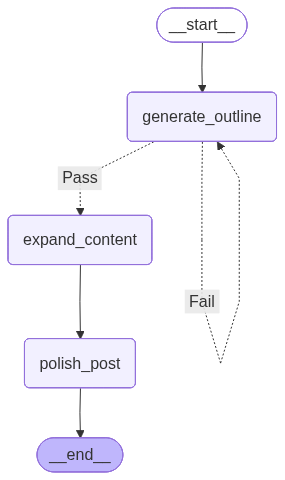

In [11]:
# Visualize the graph structure
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph visualization requires additional dependencies")
    print("")
    print("Flow with Conditional Edge:")
    print("  START → generate_outline ←──┐")
    print("              │                │")
    print("              ├─ Pass → expand_content → polish_post → END")
    print("              │                │")
    print("              └─ Fail ─────────┘ (retry loop)")